In [2]:
## Try to vectorize field boundaries from a raster image

%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append('../scripts/')
import historic_wall_inference as hwi

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
if tuple([int(x) for x in matplotlib.__version__.split('.')]) < (3, 5, 0):
    print(f'MPL version {matplotlib.__version__} is too old to support plt.axline(), so do not use this function or update to 3.5.0 or higher')
import PIL
import skimage.transform
import cv2
import pandas as pd

## Use CV2 to Binarise

In [12]:
# Load the image
image = cv2.imread("../content/tifs/masked/SK1468_mapreader.tif")

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define the orange color range (you might need to adjust these values)
lower_orange = np.array([100, 30, 0])
upper_orange = np.array([255, 200, 150])

# Create a mask to isolate orange areas
mask = cv2.inRange(image_rgb, lower_orange, upper_orange)

# Change the color of the orange areas to white
image_rgb[mask > 0] = (255, 255, 255)

# Save the modified image
cv2.imwrite('../content/tifs/masked/SK1468_modified_image.tif', cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))


True

In [30]:
from osgeo import gdal, osr

# Load the image
input_image_path = "../content/tifs/masked/SK1468_mapreader.tif"
image = gdal.Open(input_image_path)

# Read the image data
image_data = image.ReadAsArray()

# Convert to RGB format
image_rgb = np.dstack((image_data[0], image_data[1], image_data[2]))

# Define the orange color range
lower_orange = np.array([100, 30, 0])
upper_orange = np.array([255, 200, 150])

# Create a mask to isolate orange areas
mask = cv2.inRange(image_rgb, lower_orange, upper_orange)

# Change the color of the orange areas to white
image_rgb[mask > 0] = (255, 255, 255)

# Define the output file path
output_file = '../content/tifs/masked/modified_image_.tif'

# Get the image dimensions
height, width, bands = image_rgb.shape

# Create a GeoTIFF driver
driver = gdal.GetDriverByName('GTiff')

# Create a new GeoTIFF file
output_dataset = driver.Create(output_file, width, height, bands, gdal.GDT_Byte)

# Write the image data to the GeoTIFF
for i in range(bands):
    output_dataset.GetRasterBand(i + 1).WriteArray(image_rgb[:, :, i])

# Get the spatial reference system from the input image
srs = osr.SpatialReference()
srs.ImportFromWkt(image.GetProjection())

# Set the spatial reference system
output_dataset.SetProjection(srs.ExportToWkt())

# Set the geotransform
output_dataset.SetGeoTransform(image.GetGeoTransform())

# Close the dataset
output_dataset = None


# 1) Probabilistic Hough Tansform

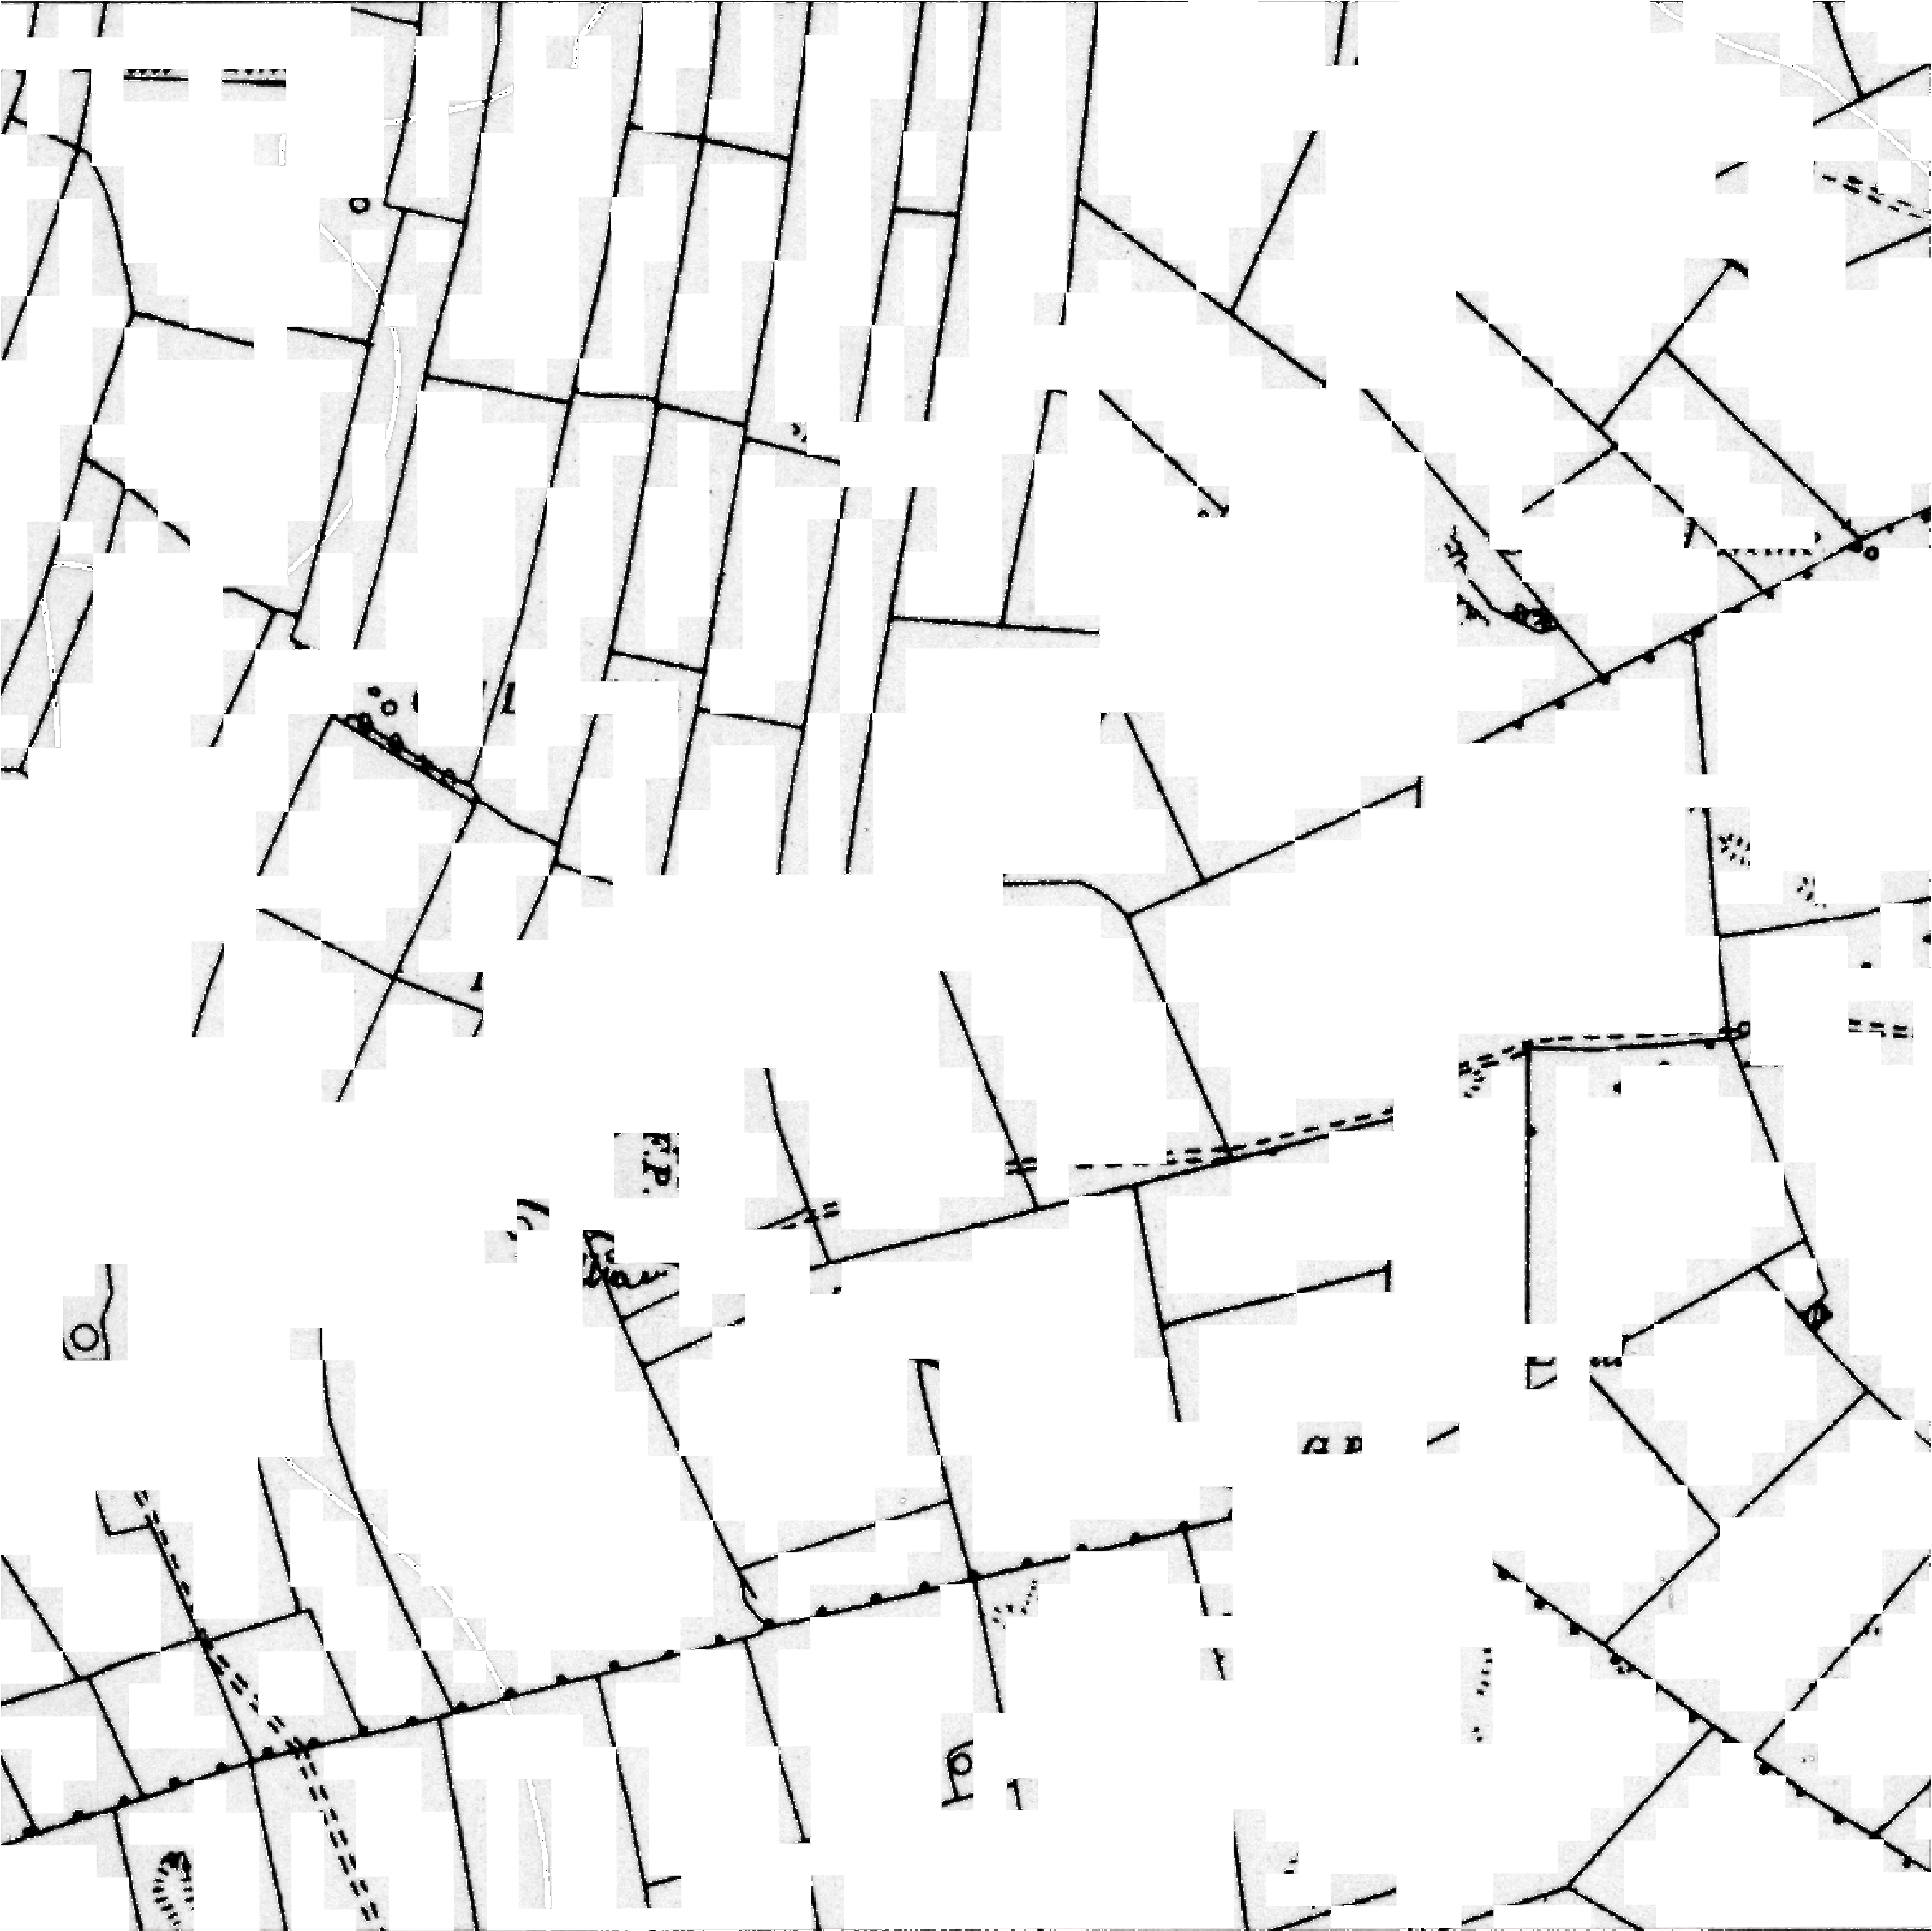

In [13]:
#im = PIL.Image.open("../content/tifs/1k_tifs/SK1468.tif")
im = PIL.Image.open('../content/tifs/masked/modified_image_.tif')
im = im.convert("L")
im  # visualise in jupyter notebook:

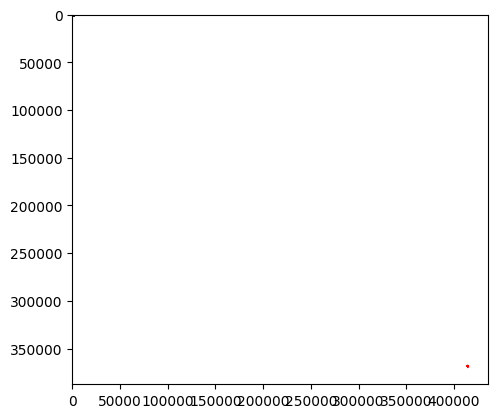

/tmp/ipykernel_5895/1277248344.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


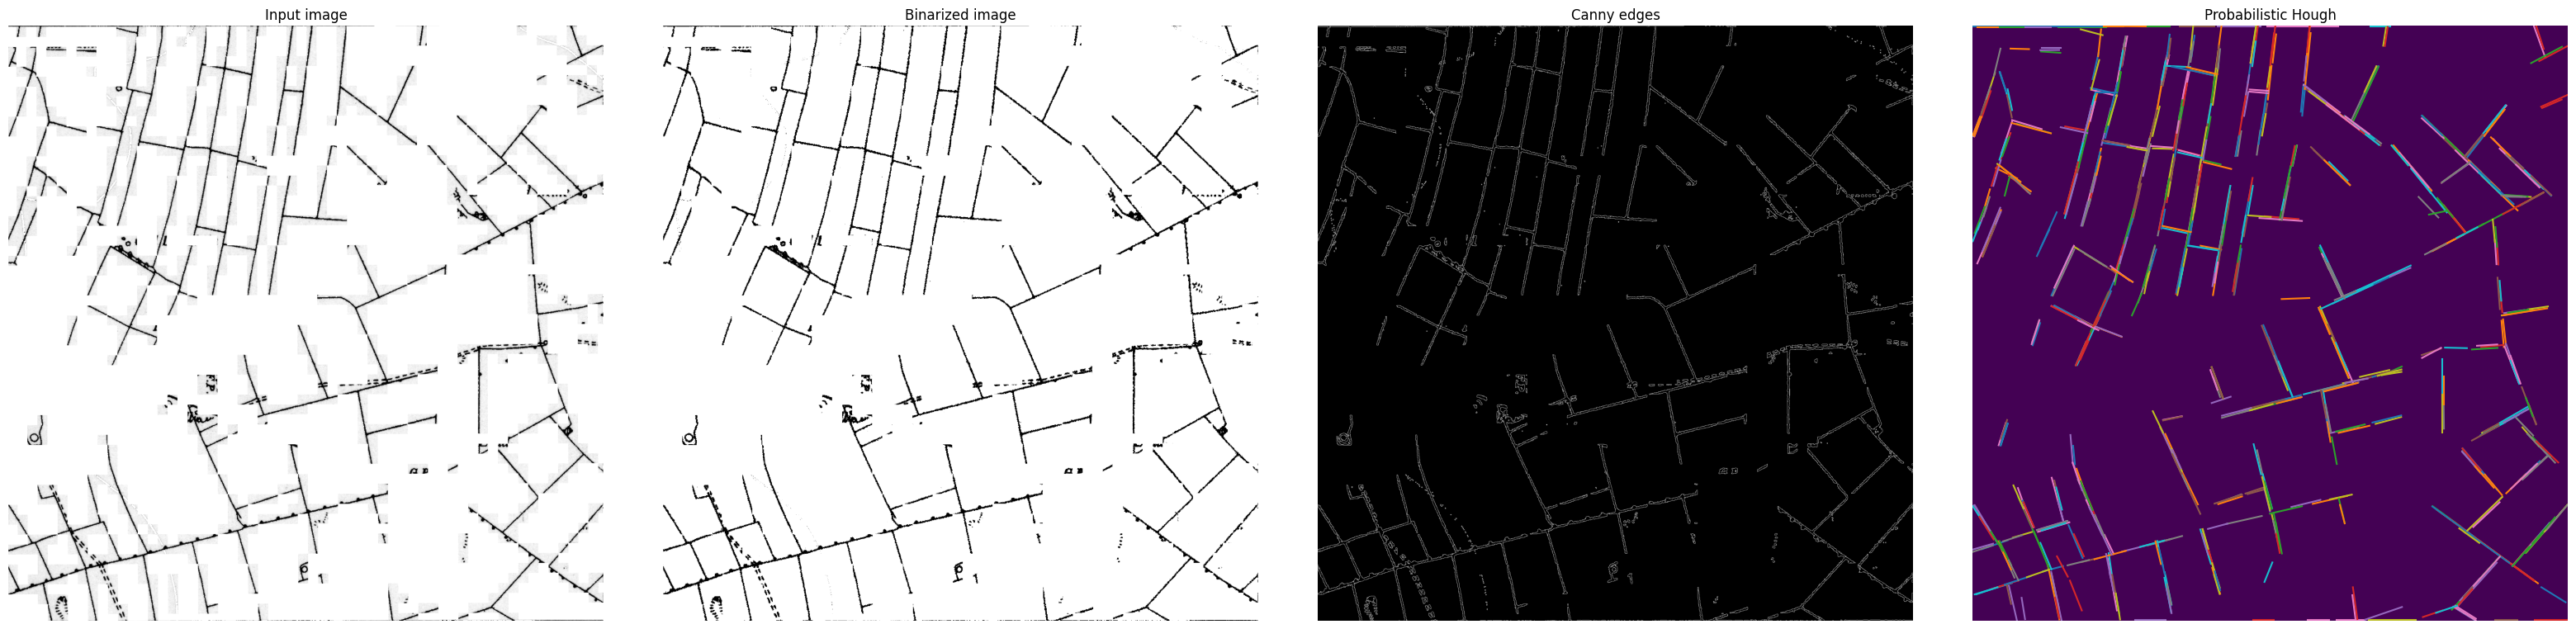

In [20]:
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
from matplotlib import cm
import geopandas as gpd
from shapely.geometry import LineString
import rasterio
from rasterio.transform import xy

# Open the GeoTIFF file to get its CRS
input_image_path = "../content/tifs/masked/SK1468_mapreader.tif"
with rasterio.open(input_image_path) as src:
    srs = src.crs
    transform = src.transform

# Load the image
im = PIL.Image.open('../content/tifs/masked/modified_image_.tif')
im = im.convert("L")
ima = np.asarray(im)

# Binarise image (assuming hwi.binarise_array() is your custom binarization function)
ima = hwi.binarise_array(ima)

# Canny edge detection
edges = canny(ima, sigma=0.9, low_threshold=0.1, high_threshold=0.9)

# Probabilistic Hough Transform
lines = probabilistic_hough_line(edges, threshold=1, line_length=70, line_gap=10)

# Transform pixel coordinates of each line to geographic coordinates
transformed_lines = []
for line in lines:
    # Transform each point in the line
    transformed_line = [xy(transform, p[1], p[0]) for p in line]  # Note the change in order of coordinates
    # Append the transformed line to the list
    transformed_lines.append(transformed_line)

# Create LineString geometries from the transformed coordinates
transformed_line_geometries = [LineString(line) for line in transformed_lines]

# Create a GeoDataFrame from the LineString objects with transformed coordinates
gdf_transformed = gpd.GeoDataFrame(geometry=transformed_line_geometries, crs=srs)

# Save the GeoDataFrame with transformed coordinates to a shapefile
output_shapefile_transformed = "../content/predictions/hough_lines_transformed.shp"
gdf_transformed.to_file(output_shapefile_transformed)

# Plot the GeoTIFF image with transformed lines on top
plt.imshow(ima, cmap='gray')
gdf_transformed.plot(ax=plt.gca(), color='red')
plt.show()

# Display
fig, axes = plt.subplots(1, 4, figsize=(40, 40), sharex=True, sharey=True, gridspec_kw={'wspace': 0.1})
ax = axes.ravel()

ax[0].imshow(im, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(ima, cmap='Greys')
ax[1].set_title('Binarized image')

ax[2].imshow(edges, cmap=cm.gray)
ax[2].set_title('Canny edges')

ax[3].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[3].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[3].set_xlim((0, ima.shape[1]))
ax[3].set_ylim((ima.shape[0], 0))
ax[3].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

### Patch Test

In [35]:
# Patch test

df = pd.read_csv(r"../content/predictions/predictions_patch_df.csv")

# lets test on a single patch
im = PIL.Image.open(df.iloc[1300]['geotiff_path'])
im = im.convert("L")
im  # visualise in jupyter notebook:

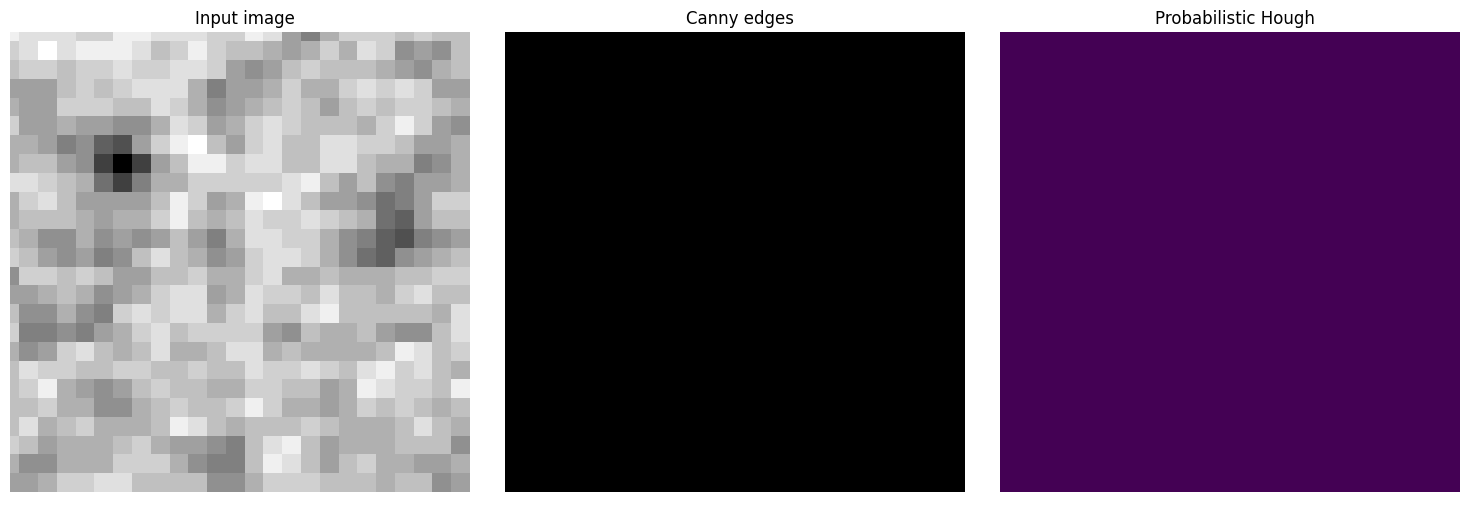

In [8]:
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
from matplotlib import cm

im = np.asanyarray(im)

## Binarise image:
#im = hwi.binarise_array(im)

edges = canny(im, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=10, line_length=2, line_gap=5)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(im, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, im.shape[1]))
ax[2].set_ylim((im.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

# Close all OpenCV windows
cv2.destroyAllWindows()

# 2) Hough Transform

/tmp/ipykernel_3083/34272638.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


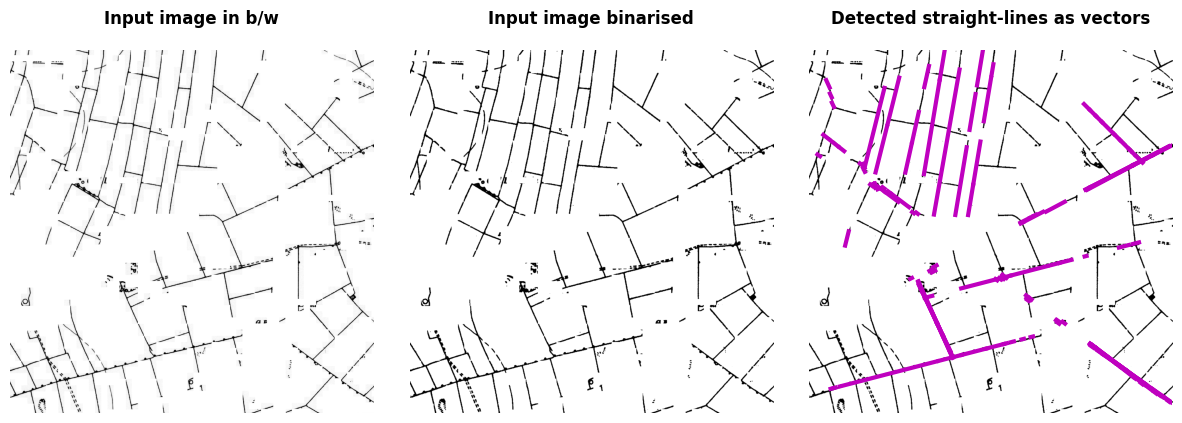

In [9]:
## Subselect part of image & convert to numpy array:
arr = np.array(im.getdata()).reshape(im.size[::-1])
#arr = arr[750:, :][:, :250]  # subselect (arbitrary) part of image because edge dectection works better on smaller images
arr = arr[5:-5 :][:, 5:-5]

## Binarise image:
arr_bin = hwi.binarise_array(arr)

## Hough transform to detect straight lines:
h, theta, d, bounds = hwi.hough_transform_array(arr_bin=arr_bin)

## Find start and end points of each line:
list_inferred_lines, df_inferred_lines = hwi.find_start_and_end_of_inferred_lines(h=h, theta=theta, d=d, arr_bin=arr_bin)
          
## Plot results:
fig, ax = plt.subplots(1, 3, figsize=(15, 15), gridspec_kw={'wspace': 0.1})

## Original image:
ax[0].imshow(arr, cmap='Greys_r')
ax[0].set_title('Input image in b/w', fontdict={'weight': 'bold'}, y=1.05)
ax[0].set_axis_off()

## Binarised image:
ax[1].imshow(arr_bin, cmap=matplotlib.cm.gray_r)
ax[1].set_title('Input image binarised', fontdict={'weight': 'bold'}, y=1.05)
ax[1].set_axis_off()

## Binarised image, to be overlayed with detected lines
ax[2].imshow(arr_bin, cmap=matplotlib.cm.gray_r)
ax[2].set_ylim((arr_bin.shape[0], 0))
ax[2].set_xlim((0, arr_bin.shape[1]))
ax[2].set_axis_off()
ax[2].set_title('Detected straight-lines as vectors', fontdict={'weight': 'bold'}, y=1.05)
## Plot inferred lines:
for line in list_inferred_lines:
    ax[2].plot(line[0], line[1], c='m', linewidth=3)

plt.tight_layout()

### Patch Test

In [5]:
# lets test on a single patch
im = PIL.Image.open(df.iloc[1200]['geotiff_path'])
im = im.convert("L")
im  # visualise in jupyter notebook:

C:\Users\alexad\AppData\Local\Temp\ipykernel_23516\1008291764.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


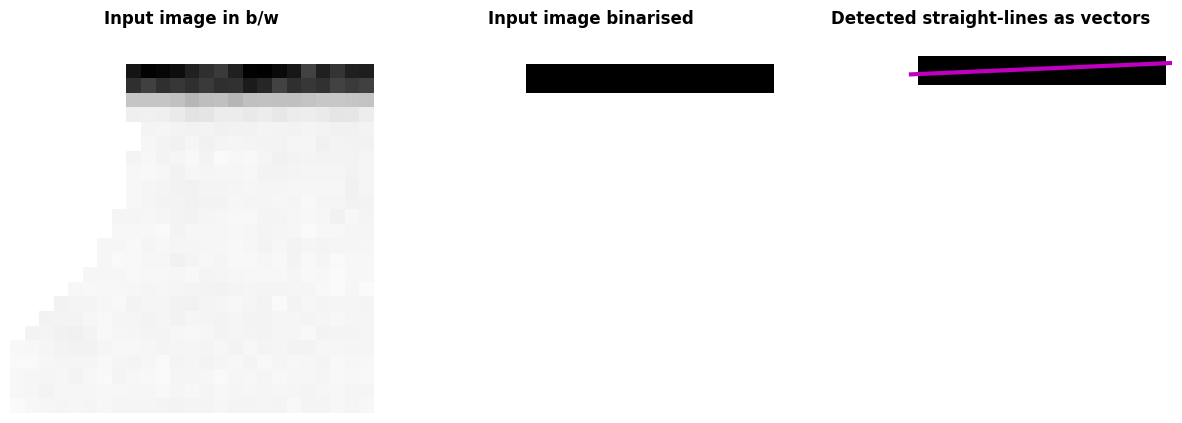

In [6]:
## Subselect part of image & convert to numpy array:
arr = np.array(im.getdata()).reshape(im.size[::-1])
#arr = arr[750:, :][:, :250]  # subselect (arbitrary) part of image because edge dectection works better on smaller images
#arr = arr[5:-5 :][:, 5:-5]

## Binarise image:
arr_bin = hwi.binarise_array(arr)

## Hough transform to detect straight lines:
h, theta, d, bounds = hwi.hough_transform_array(arr_bin=arr_bin)

## Find start and end points of each line:
list_inferred_lines, df_inferred_lines = hwi.find_start_and_end_of_inferred_lines(h=h, theta=theta, d=d, arr_bin=arr_bin)
          
## Plot results:
fig, ax = plt.subplots(1, 3, figsize=(15, 15), gridspec_kw={'wspace': 0.1})

## Original image:
ax[0].imshow(arr, cmap='Greys_r')
ax[0].set_title('Input image in b/w', fontdict={'weight': 'bold'}, y=1.05)
ax[0].set_axis_off()

## Binarised image:
ax[1].imshow(arr_bin, cmap=matplotlib.cm.gray_r)
ax[1].set_title('Input image binarised', fontdict={'weight': 'bold'}, y=1.05)
ax[1].set_axis_off()

## Binarised image, to be overlayed with detected lines
ax[2].imshow(arr_bin, cmap=matplotlib.cm.gray_r)
ax[2].set_ylim((arr_bin.shape[0], 0))
ax[2].set_xlim((0, arr_bin.shape[1]))
ax[2].set_axis_off()
ax[2].set_title('Detected straight-lines as vectors', fontdict={'weight': 'bold'}, y=1.05)
## Plot inferred lines:
for line in list_inferred_lines:
    ax[2].plot(line[0], line[1], c='m', linewidth=3)

plt.tight_layout()

In [73]:
# try looping through the images

# Create an empty DataFrame to store inferred lines
df_inferred_lines_all = pd.DataFrame(columns=['x', 'y'])

# Loop through rows where label is 'wall'
for index, row in df[df['label'] == 'wall'].iterrows():
    # Load the image
    im = PIL.Image.open(row['image_path'])
    
    # Binarise image:
    arr_bin = hwi.binarise_array(arr)

    # Hough transform to detect straight lines:
    h, theta, d, bounds = hwi.hough_transform_array(arr_bin=arr_bin)

    # Find start and end points of each line:
    list_inferred_lines, df_inferred_lines = hwi.find_start_and_end_of_inferred_lines(h=h, theta=theta, d=d, arr_bin=arr_bin)

    # Concatenate the inferred lines to df_inferred_lines_all
    df_inferred_lines_all = pd.concat([df_inferred_lines_all, df_inferred_lines], ignore_index=True)

# Print or use df_inferred_lines_all as needed
df_inferred_lines_all.head(3)

,x,y
0,"(0, 25)","(4.469601539088952, 16.934141740424742)"
1,"(0, 25)","(4.469601539088952, 16.934141740424742)"
2,"(0, 25)","(4.469601539088952, 16.934141740424742)"
